In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from colpali_engine.models import ColPali, ColPaliProcessor
from PIL import Image
from qdrant_client import QdrantClient
from qdrant_client.http import models

In [ ]:
collection_name = "pdfs-2"
dataset = list(Path("../data/jpeg/").rglob("*jpg"))
qdrant_client = QdrantClient(
    url="http://ml.n19:6333",
    api_key="",
)

# Initialize ColPali model and processor
model_name = "vidore/colpali-v1.2"  # Use the latest version available
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained("vidore/colpali-v1.2")

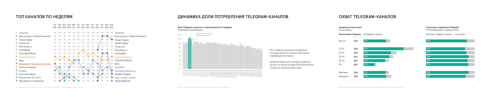

In [ ]:
# [pin]

files = dataset[:10]
fig, axes = plt.subplots(len(files) // 6, 3, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    img = Image.open(files[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
def request_query_embedder(query_text: str):
    with torch.no_grad():
        batch_query = colpali_processor.process_queries([query_text]).to(
            colpali_model.device
        )
        query_embedding = colpali_model(**batch_query)
    return query_embedding[0].cpu().float().numpy().tolist()


def query_multivector(multivector, top_k: int = 10):
    start_time = time.time()
    search_result = qdrant_client.query_points(
        collection_name=collection_name,
        query=multivector_query,
        limit=top_k,
        timeout=100,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                ignore=False,
                rescore=True,
                oversampling=2.0,
            )
        ),
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Search completed in {elapsed_time:.4f} seconds")
    return search_result


# query_text = "Как развивается геймдев в Москве?"
query_text = "Как за 10 лет изменилось количество телепрограмм, привлекающих более 4-х млн. зрителей в Великобритании?"
# query_text = "Какие меры поддержки приняты для работников игровой индустрии в москве?"
multivector_query = request_query_embedder(query_text)
search_result = query_multivector(multivector_query)

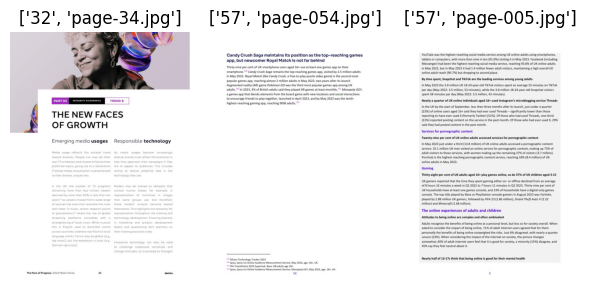

In [ ]:
# [pin]

fig, axes = plt.subplots(len(search_result.points) // 6, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    point = search_result.points[i]
    idx = point.id
    img = Image.open(dataset[idx])
    ax.set_title(str(dataset[idx]).split("/")[-2:])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
import pprint

from utils import request_with_image

response = request_with_image(
    query_text=query_text,
    image_path=dataset[idx],
    system_prompt="You are required to give a clear answer to the question posed",
)

In [ ]:
# [pin]

pprint.pprint(response.choices[0].message.content)

('Извините, но мне сложно отыскать информацию о количестве телепрограмм за 10 '
 'лет в Великобритании, которая бы привлекла более 4-х млн. зрителей. '
 'Пожалуйста, предоставьте мне более точные данные или уточните вопрос.')
